# Natural Catastrophe (NatCat) & Insurance Risk Knowledge Graph

This notebook implements the **Data Loading & Knowledge Graph Construction** phase of an insurance-focused analytics use case.

The primary business objective is to bridge the gap between **Physical Risk** (Natural Disasters) and **Financial Protection** (Insurance Penetration) by integrating disparate spatial, economic, and historical loss datasets into a unified Neo4j Knowledge Graph.

### Business Context: Insurance Perspective

Natural catastrophes (NatCat) such as floods, earthquakes, and storms pose significant risks to insurers and reinsurers. Accurately assessing and managing these risks requires a comprehensive understanding of both the **economic exposure** (i.e., the value of assets at risk) and the **hazard vulnerability** (i.e., the susceptibility of those assets to damage).

For Re/Insurers, understanding the interaction between economic exposure and hazard vulnerability is critical for:

- **Accumulation Control**: Preventing excessive concentration of risk in specific geographic zones ([NUTS](https://ec.europa.eu/eurostat/web/nuts) regions).
- **Protection Gap Analysis**: Identifying regions with high economic value and vulnerability but low insurance penetration (Gross Written Premiums).
- **Underwriting Strategy**: Informing risk appetite based on historical loss frequency and severity.

### Technical Approach

We employ a **Spatial ETL (Extract, Transform, Load)** pipeline:
  
- **Ingest** high-resolution gridded exposure data (LitPop), national insurance stats (EIOPA), and hazard data (DRMKC).
- **Transform** & **Aggregate** granular spatial data into administrative hierarchies (NUTS1/2/3).
- **Load** the structured data into a graph model that explicitly links *Location*, *Risk*, and *Financial Capacity*.

We make use of the NUTS (Nomenclature of Territorial Units for Statistics) administrative hierarchy to spatially aggregate and relate data at multiple geographic levels. This approach enables multi-scale risk analysis, from local (NUTS3) to national (Country) levels, and can be represented very naturally in a graph database like Neo4j.

## Data Sources & Lineage

The following open datasets are used in this use case:

| Source | Dataset | Domain | Business Utility |
| :--- | :--- | :--- | :--- |
| **[LitPop](https://www.research-collection.ethz.ch/entities/researchdata/12dcfc4f-9d03-463a-8d6b-76c0dc73cdc8)** | Global Exposure Data | **Exposure Management** | Proxy for Total Insurable Value (TIV) at 30 arc-sec resolution. |
| **[EIOPA](https://www.eiopa.europa.eu/tools-and-data/insurance-statistics_en#premiums-claims-and-expenses)** | Insurance Statistics | **Market Intelligence** | Aggregated Premiums, Claims & Expenses by Line of Business. |
| **[DRMKC](https://drmkc.jrc.ec.europa.eu/risk-data-hub-api/docs/)** | Risk Data Hub | **Catastrophe Modelling** | Vulnerability indicators and historical loss event catalog. |

If you decide to run this notebook, please ensure you have access to the above datasets and have set up the necessary environment variables as described in the sections below. In the case of DRMKC, you will need to register for an API token, while for EIOPA and LitPop, the datasets are openly accessible and downloadable. This notebook assumes you have already downloaded the required datasets and placed them in a `.data` directory.

> **Note**: DRMKC API tokens expire periodically. Please update the `DRMKC_TOKEN` in your `.env` file if you encounter authentication errors.

## Environment Setup & Configuration

This project adheres to the **12-Factor App** methodology, strictly separating configuration from code.

**Prerequisites:**

*   **Docker** (optional, for running Neo4j locally).
*   **Neo4j Instance**: A running database (AuraDB or Local) requires URI/Auth credentials.
*   **Python 3.8+**: Recommended virtual environment.

**Configuration (`.env` file):**

Ensure a `.env` file exists in the project root with the following keys:
*   `ISO_A3_COUNTRY_CODE`: The target country for analysis (e.g., 'ITA', 'DEU', 'BEL', etc - you should note that NUTS regions are only defined for European countries).
*   `DRMKC_TOKEN`: Access token for the Risk Data Hub API.
*   `NEO4J_URI`: Bolt connection URI (e.g., `bolt://localhost:7687`).
*   `NEO4J_USER`, `NEO4J_PASSWORD`: Database credentials.
*   `CACHE_DIR`: Directory for caching API responses (speeds up re-runs).

In [1]:
# Load .env
import os
from dotenv import load_dotenv

load_dotenv()

LOAD_COUNTRY_ISO_A3 = os.getenv("ISO_A3_COUNTRY_CODE")
DRMKC_TOKEN = os.getenv("DRMKC_TOKEN")
CACHE_DIR = os.getenv("CACHE_DIR")

In [2]:
import pycountry

# Get country full name and alpha-2 code
country_full = pycountry.countries.get(alpha_3=LOAD_COUNTRY_ISO_A3).name.upper()
country_alpha2 = pycountry.countries.get(alpha_3=LOAD_COUNTRY_ISO_A3).alpha_2

## Economic Exposure Data (LitPop)

### Business Context: Accumulation Risk & Total Insurable Value (TIV)

In Property & Casualty (P&C) insurance, **Exposure** refers to the value of physical assets (buildings, infrastructure) and lives at risk. 

We utilize the **[LitPop](https://www.research-collection.ethz.ch/entities/researchdata/12dcfc4f-9d03-463a-8d6b-76c0dc73cdc8)** dataset as a high-resolution proxy for **Total Insurable Value (TIV)**. By mapping population count and nightlight intensity to physical capital, we can identify "hotspots" of economic value.

*   **Risk Management Goal**: Accurately map where value is concentrated to model potential maximum losses (PML) from a catastrophic event.
*   **Granularity**: 30 arc-second grid (~1km at equator).

In this section, we load the gridded data and perform a **Spatial Join** to aggregate these micro-exposures up to **NUTS3** administrative regions, aligning them with insurance reporting standards.

In [3]:
import pandas as pd
econ_exposure_df = pd.read_csv(f'.data/LitPop_v1_2/LitPop_pc_30arcsec_{LOAD_COUNTRY_ISO_A3}.csv')

# Display the first few rows of the DataFrame
econ_exposure_df.head()

,value,latitude,longitude,region_id
0,1.688470e+06,51.087500,2.529167,56
1,5.413426e+07,51.079167,2.529167,56
2,4.227134e+06,51.087500,2.537500,56
3,3.066045e+07,51.079167,2.537500,56
4,5.213215e+07,51.070833,2.537500,56


To develop an intuitive understanding of the data and its relevance to insurance risk, we will visualize the spatial distribution of exposure for the country of interest.

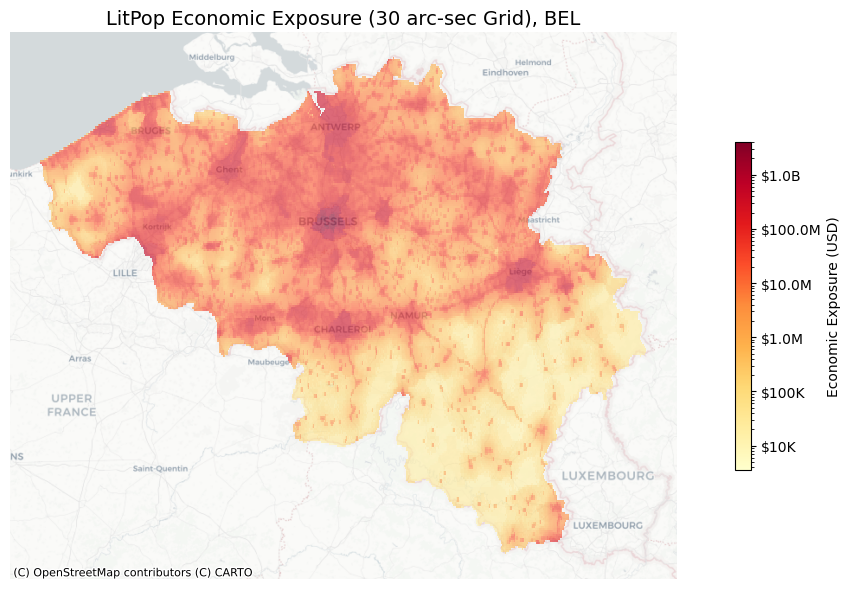

In [4]:
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm
from shapely.geometry import box

# Helper for currency formatting
def currency_fmt(x, pos):
    if x >= 1e9: return f'${x*1e-9:.1f}B'
    elif x >= 1e6: return f'${x*1e-6:.1f}M'
    elif x >= 1e3: return f'${x*1e-3:.0f}K'
    else: return f'${x:.0f}'

# Convert Points to 30-arc-second Polygons
# 30 arc-seconds = 30/3600 degrees = 1/120 degrees ≈ 0.008333... degrees
cell_size = 1 / 120 

# Create square polygons centered on the points
# We subtract/add half the cell_size to the center coordinates
geometry = [
    box(x - cell_size/2, y - cell_size/2, x + cell_size/2, y + cell_size/2)
    for x, y in zip(econ_exposure_df.longitude, econ_exposure_df.latitude)
]

# Create the GeoDataFrame with Polygons
gdf_poly = gpd.GeoDataFrame(econ_exposure_df, geometry=geometry, crs="EPSG:4326")

# Filter and Project
gdf_plot = gdf_poly[gdf_poly['value'] > 0]
gdf_plot = gdf_plot.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

gdf_plot.plot(
    ax=ax,
    column='value',
    cmap='YlOrRd',
    norm=LogNorm(vmin=gdf_plot['value'].min(), vmax=gdf_plot['value'].max()),
    legend=True,
    legend_kwds={
        'label': "Economic Exposure (USD)",
        'format': ticker.FuncFormatter(currency_fmt),
        'shrink': 0.6
    },
    # No markersize needed! Polygons have intrinsic size.
    # We set linewidth=0 to remove borders so they blend into a heatmap
    linewidth=0,
    edgecolor='none',
    alpha=0.6
)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.title(f"LitPop Economic Exposure (30 arc-sec Grid), {LOAD_COUNTRY_ISO_A3}", fontsize=14)
plt.tight_layout()
plt.savefig("renderings/litpop_exposure_grid.png", dpi=300, bbox_inches='tight')
plt.show()

We also want to map the gridded exposure data to the NUTS3 administrative regions to understand how economic value is distributed across these insurance-relevant geographic units. This spatial aggregation is crucial for aligning our analysis with industry practices, as insurers often report and underwrite risk based on these administrative boundaries.

In [5]:
import geopandas as gpd
import pandas as pd

# Convert exposure DataFrame to GeoDataFrame
gdf_points = gpd.GeoDataFrame(
    econ_exposure_df,
    geometry=gpd.points_from_xy(econ_exposure_df.longitude, econ_exposure_df.latitude),
    crs="EPSG:4326"
)

# Load official NUTS data (Level 3)
# Using 2021 definitions, scale 1:10 Million
nuts_url = "https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_10M_2021_4326.geojson"

print("Downloading NUTS boundary data...")
nuts_all = gpd.read_file(nuts_url)

# Filter for Level 3 only, and for the correct country
nuts3_polygons = nuts_all[(nuts_all['LEVL_CODE'] == 3) & (nuts_all['CNTR_CODE'] == country_alpha2)].copy()

# Perform Spatial Join
# We keep the points (left) and add attributes from the polygons (right)
print("Performing spatial join (this may take a moment)...")
# We only select the columns we need from the shapefile to keep it clean
# Note: 'MOUNT_TYPE', 'URBN_TYPE' and 'COAST_TYPE' are standard attributes in GISCO datasets
target_cols = ['geometry', 'NUTS_ID', 'NAME_LATN', 'NUTS_NAME', 'MOUNT_TYPE', 'URBN_TYPE', 'COAST_TYPE']
joined_gdf = gpd.sjoin(gdf_points, nuts3_polygons[target_cols], how="left", predicate="within")

# Derive Parent Codes (NUTS1 and NUTS2)
# NUTS codes are hierarchical: 
#   NUTS1: 1st 3 chars (e.g., 'BE1')
#   NUTS2: 1st 4 chars (e.g., 'BE10')
#   NUTS3: 1st 5 chars (e.g., 'BE100')
joined_gdf['NUTS1'] = joined_gdf['NUTS_ID'].str.slice(0, 3)
joined_gdf['NUTS2'] = joined_gdf['NUTS_ID'].str.slice(0, 4)
joined_gdf['NUTS3'] = joined_gdf['NUTS_ID'] # Explicitly requested as separate col

# Clean up and merge back to original DataFrame
# We drop the 'geometry' and 'index_right' artifacts from the join
columns_to_add = ['NUTS_ID', 'NUTS1', 'NUTS2', 'NUTS3', 
                  'NAME_LATN', 'NUTS_NAME', 'MOUNT_TYPE', 'URBN_TYPE', 'COAST_TYPE']

# Assign columns back to the original dataframe based on index
econ_exposure_df[columns_to_add] = joined_gdf[columns_to_add]

# Keep only points that geometrically fall inside the country's NUTS regions
# This is to avoid "spillover" from neighboring countries
econ_exposure_df = econ_exposure_df[econ_exposure_df['NUTS_ID'].str.startswith(country_alpha2, na=False)]

# Set MOUNT_TYPE, URBN_TYPE and COAST_TYPE to integers
econ_exposure_df['MOUNT_TYPE'] = econ_exposure_df['MOUNT_TYPE'].astype('Int8')
econ_exposure_df['URBN_TYPE'] = econ_exposure_df['URBN_TYPE'].astype('Int8')
econ_exposure_df['COAST_TYPE'] = econ_exposure_df['COAST_TYPE'].astype('Int8')

econ_exposure_df.head()

Performing spatial join (this may take a moment)...


,value,latitude,longitude,region_id,NUTS_ID,NUTS1,NUTS2,NUTS3,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE
15,7.154833e+06,51.087500,2.554167,56,BE258,BE2,BE25,BE258,Arr. Veurne,Arr. Veurne,4,2,1
16,2.093725e+07,51.079167,2.554167,56,BE258,BE2,BE25,BE258,Arr. Veurne,Arr. Veurne,4,2,1
26,7.900114e+06,51.087500,2.562500,56,BE258,BE2,BE25,BE258,Arr. Veurne,Arr. Veurne,4,2,1
27,2.231022e+07,51.079167,2.562500,56,BE258,BE2,BE25,BE258,Arr. Veurne,Arr. Veurne,4,2,1
28,2.622490e+07,51.070833,2.562500,56,BE258,BE2,BE25,BE258,Arr. Veurne,Arr. Veurne,4,2,1


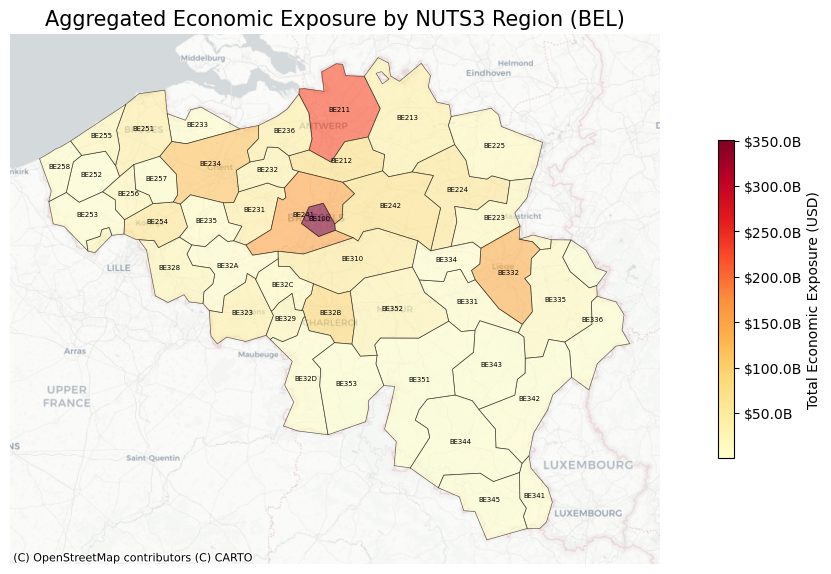

In [6]:
# Plot an aggregated map by NUTS3 region

# Aggregate exposure by NUTS3 region
# We sum the 'value' for each region
nuts3_agg = econ_exposure_df.groupby('NUTS3')[['value']].sum().reset_index()

# Prepare the Geometry (Polygons)
map_gdf = nuts3_polygons.copy()

# Merge Data with Geometry
# We use a 'left' join to keep all regions in the country, even if they have 0 exposure (they will be NaN)
map_gdf = map_gdf.merge(nuts3_agg, left_on='NUTS_ID', right_on='NUTS3', how='left')

# Fill NaN values with 0 for plotting (optional, depends if you want them grey or colored 0)
map_gdf['value'] = map_gdf['value'].fillna(0)

# Project for Plotting
# Convert to Web Mercator for Contextily basemaps
map_gdf = map_gdf.to_crs(epsg=3857)

# Create the Plot
fig, ax = plt.subplots(figsize=(12, 6))

# Define currency formatter
def currency_fmt(x, pos):
    if x >= 1e9: return f'${x*1e-9:.1f}B'
    elif x >= 1e6: return f'${x*1e-6:.1f}M'
    elif x >= 1e3: return f'${x*1e-3:.0f}K'
    else: return f'${x:.0f}'

# Plot the polygons (Choropleth)
# We use 'alpha=0.6' so we can see the basemap labels underneath
map_gdf.plot(
    ax=ax,
    column='value',
    cmap='YlOrRd',
    legend=True,
    legend_kwds={
        'label': "Total Economic Exposure (USD)",
        'format': ticker.FuncFormatter(currency_fmt),
        'shrink': 0.6
    },
    alpha=0.6,
    edgecolor='black',
    linewidth=0.5
)

# Add basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

# Add labels
# This can be cluttered, so we only do it for high-value regions or all if legible
for idx, row in map_gdf.iterrows():
    # Only label if value is significant (e.g., > 0)
    if row['value'] > 0:
        ax.annotate(
            text=row['NUTS_ID'], # Or row['NUTS_NAME']
            xy=(row.geometry.centroid.x, row.geometry.centroid.y),
            ha='center', fontsize=5, color='black'
        )

ax.set_axis_off()
plt.title(f"Aggregated Economic Exposure by NUTS3 Region ({LOAD_COUNTRY_ISO_A3})", fontsize=15)
plt.tight_layout()

# Save
plt.savefig("renderings/litpop_nuts3_agg_map.png", dpi=300, bbox_inches='tight')
plt.show()

The above exposure data aggregated into a NUTS grid will be key later on for analysis.

## Insurance Statistics (EIOPA)

### Business Context: Market Penetration & Financial Performance

While LitPop gives us the *Potential* market size (economic exposure), **[EIOPA](https://www.eiopa.europa.eu/tools-and-data/insurance-statistics_en#premiums-claims-and-expenses)** statistics provide the *Actual* market state.

We integrate aggregated country-level data on:

*   **Gross Written Premiums (GWP)**: A measure of market revenue and insurance penetration.
*   **Gross Claims Paid**: Indicating realized risk transfer and loss severity.
*   **Expenses**: Operational efficiency metrics.

### Analytical Value

By comparing **LitPop Exposure** (Demand) vs **EIOPA Premiums** (Supply), we can estimate the **Insurance Protection Gap** at a national level. In the Knowledge Graph, this allows us to query: *Which regions have high exposure to specific hazards but relatively low insurance density?*

> Note that EIOPA provides country level data only, in our analysis later on we will simulate region level statistics synthetically. Insurers and other insurance industry organisations will have their own region level data which can be used.

In [7]:
# Load the EIOPA data for the specified country
eiopa_df = pd.read_csv(f'.data/SA_Premiums_Claims_Expenses.csv')

In [8]:
eiopa_country_df = eiopa_df[eiopa_df['Reporting country'] == country_full]

eiopa_country_df = eiopa_country_df.copy()
# Clean the reference period string (remove 'Y') and convert to integer year
eiopa_country_df['Reference period'] = eiopa_country_df['Reference period'].str.replace('Y', '').astype(int) 

eiopa_country_df.head()

,Reporting country,Reference period,Item,Business type,Item code,Value,Date of extraction (yyyymmdd),"Number of submissions (per reporting country, reference date and undertaking type)"
820,BELGIUM,2016,Premiums written,Non-Life,R0101,NaN,20250723,66
821,BELGIUM,2016,Gross - Direct Business,Non-Life,R0110,13942.246135,20250723,66
822,BELGIUM,2016,Gross - Proportional reinsurance accepted,Non-Life,R0120,588.096503,20250723,66
823,BELGIUM,2016,Gross - Non-proportional reinsurance accepted,Non-Life,R0130,81.483368,20250723,66
824,BELGIUM,2016,Reinsurers' share,Non-Life,R0140,2893.043643,20250723,66


In [9]:
# Show the shapes of the dataframes
print(f"Economic Exposure DataFrame shape: {econ_exposure_df.shape}")
print(f"EIOPA DataFrame shape: {eiopa_country_df.shape}")

Economic Exposure DataFrame shape: (55127, 13)
EIOPA DataFrame shape: (820, 8)


## Risk Data (DRMKC)

### Business Context: Physical Risk & Vulnerability

Physical risk assessment requires two components: **Hazard** (frequency/intensity of events) and **Vulnerability** (susceptibility of assets to damage).

We query the **[DRMKC Risk Data Hub API](https://drmkc.jrc.ec.europa.eu/risk-data-hub-api/docs/)** to enrich our graph with a multitude of vulnerability indicators and a catalog of historical loss events for the target country. For example:

- **Vulnerability Indicators**:
    *   *Social Vulnerability*: Age dependency, education levels (correlates with recovery capacity).
    *   *Economic Vulnerability*: Household income stability.
- **Historical Loss Catalog**:
    *   Past event data (Flood, Storm, Earthquake).
    *   Economic losses and fatalities.

> **Underwriting Insight**: Historical loss data is crucial for validating catastrophe models and setting technical pricing rates. Vulnerability scores help refine loss expectancy curves beyond simple exposure amounts.

> Note that the DRMKC API has rate limits. To avoid hitting these during development, we cache responses locally. If you modify the code that queries the API, consider clearing the cache to fetch fresh data. Also note that for large countries, downloading all historical events may take some time.

In [10]:
import requests
import joblib

cache = joblib.Memory(location=CACHE_DIR, verbose=0)

@cache.cache
def get_vulnerabilities_by_country(country_code, nuts_level,token, nuts_filter=None):
    """
    Fetches vulnerability data for a specific NUTS3 region from the DRMKC Risk Data Hub API.

    Args:
        country_code (str): The country code (e.g., 'BE').
        nuts_level (int): The NUTS level (e.g., 3 for NUTS3).
        token (str): Bearer token for API authentication.
        nuts_filter (str, optional): Additional filter for NUTS regions.
    Returns:
        list: A list of vulnerabilities in GeoJSON format for the specified region.
    """
    base_url = "https://drmkc.jrc.ec.europa.eu/risk-data-hub-api"
    endpoint = "/risk-data-hub-service/risks/vulnerability/items"
    
    # Set up parameters to filter by the NUTS3 code (unit_code)
    # The API typically uses CQL expressions for filtering, e.g.,
    # filter=admin_unit_code = 'BE100'
    params = {
        "admin_unit_country_code":f"{country_code}",
        "admin_unit_level_code": f"{nuts_level}",
        "limit": 10000
    }
    if nuts_filter:
        params["filter"] = f"admin_unit_code={nuts_filter}"
    
    # Set bearer token for authentication
    headers = {
        "Authorization": f"Bearer {token}"
    }

    try:
        response = requests.get(f"{base_url}{endpoint}", params=params, headers=headers)
        response.raise_for_status()  # Raise an exception for HTTP errors
        
        data = response.json()
        
        # The API usually returns a list or a paginated object. 
        # We return the raw data or the specific list depending on structure.
        return data

    except requests.exceptions.RequestException as e:
        return []

In [11]:
@cache.cache
def get_losses_by_country(country_code, nuts_level, token, nuts_filter=None):
    """
    Fetches loss data for a specific country from the DRMKC Risk Data Hub API.

    Args:
        country_code (str): The country code (e.g., 'BE').
        nuts_level (int): The NUTS level (e.g., 2 for NUTS2).
        token (str): Bearer token for API authentication.
        nuts_filter (str, optional): Additional filter for NUTS regions.
    Returns:
        list: A list of losses in GeoJSON format for the specified region.
    """
    base_url = "https://drmkc.jrc.ec.europa.eu/risk-data-hub-api"
    endpoint = "/risk-data-hub-service/losses/losses/items"
    
    # Set up parameters to filter by the country code
    # The API typically uses CQL expressions for filtering, e.g.,
    # filter=admin_unit_code = 'BE100'
    params = {
        "admin_unit_country_code":f"{country_code}",
        "admin_unit_level_code": f"{nuts_level}",
        "limit": 10000
    }
    
    if nuts_filter:
        params["filter"] = f"admin_unit_code={nuts_filter}"
        
    # Set bearer token for authentication
    headers = {
        "Authorization": f"Bearer {token}"
    }

    try:
        response = requests.get(f"{base_url}{endpoint}", params=params, headers=headers)
        response.raise_for_status()  # Raise an exception for HTTP errors
        
        data = response.json()
        
        # The API usually returns a list or a paginated object. 
        # We return the raw data or the specific list depending on structure.
        return data

    except requests.exceptions.RequestException as e:
        return []

In [12]:
from tqdm.notebook import tqdm

# Collect vulnerabilities for ALL NUTS3 regions found in the economic exposure data

# Get unique NUTS3 codes (drop NaNs if any)
unique_nuts3_codes = econ_exposure_df['NUTS3'].dropna().unique()

all_vuls_list = []

for nuts3_code in tqdm(unique_nuts3_codes, desc="Fetching NUTS3 vulnerability data"):
    # Fetch from API
    r_data = get_vulnerabilities_by_country(country_alpha2, 3, DRMKC_TOKEN, nuts_filter=nuts3_code)
    
    # Process if we got features back
    if r_data and 'features' in r_data:
        # Extract properties
        props = [item['properties'] for item in r_data['features']]
        all_vuls_list.extend(props)
    else:
        print(f"No data returned for NUTS3 code: {nuts3_code}")
        continue

# Create the final dataframe
vulnerabilities_df = pd.DataFrame(all_vuls_list)

print(f"Vulnerabilities DataFrame shape: {vulnerabilities_df.shape}")

Fetching NUTS3 vulnerability data:   0%|          | 0/44 [00:00<?, ?it/s]

Vulnerabilities DataFrame shape: (73472, 15)


In [13]:
vulnerabilities_df.head()

,vulnerability_measure,vulnerability_type,admin_unit_code,admin_unit_name_latin,admin_unit_level,admin_unit_country_code,admin_unit_country_name_latin,vulnerability_code,vulnerability_parent_code,vulnerability_year,vulnerability_score,admin_unit_name,admin_unit_parent_code,admin_unit_level_code,admin_unit_country_name
0,Population density,indicator,BE258,Veurne,NUTS3,BE,Belgium,lvi-soc-pop-pop_densyt,lvi-soc-pop,2005,3.97218,Arr. Veurne,BE25,3,Belgique/België
1,Net migration,indicator,BE258,Veurne,NUTS3,BE,Belgium,lvi-soc-pop-net_migrtn,lvi-soc-pop,2005,5.53410,Arr. Veurne,BE25,3,Belgique/België
2,Young dependency,indicator,BE258,Veurne,NUTS3,BE,Belgium,lvi-soc-dep-young_depy,lvi-soc-dep,2005,4.89939,Arr. Veurne,BE25,3,Belgique/België
3,Old dependency,indicator,BE258,Veurne,NUTS3,BE,Belgium,lvi-soc-dep-old_depncy,lvi-soc-dep,2005,5.20474,Arr. Veurne,BE25,3,Belgique/België
4,NUTS3 GDP per capita vs country average,indicator,BE258,Veurne,NUTS3,BE,Belgium,lvi-eco-fin-gdp_vs_cnt,lvi-eco-fin,2005,6.65946,Arr. Veurne,BE25,3,Belgique/België


In [14]:
# Show unique `vulnerability_code` present in the vulnerabilities dataframe
unique_vul_codes = vulnerabilities_df['vulnerability_code'].unique()

print(f"Unique vulnerability codes present: {unique_vul_codes}")

Unique vulnerability codes present: <StringArray>
['lvi-soc-pop-pop_densyt', 'lvi-soc-pop-net_migrtn', 'lvi-soc-dep-young_depy',
 'lvi-soc-dep-old_depncy', 'lvi-eco-fin-gdp_vs_cnt', 'lvi-eco-fin-gr_val_add',
 'lvi-eco-tec-patent_epo', 'lvi-soc-acc-avg_dis_hl', 'lvi-soc-acc-locl_srvcs',
 'lvi-eco-tec-powrplants', 'lvi-env-env-green_urbs', 'lvi-env-env-lnd_tk_int',
            'lvi-soc-pop',            'lvi-soc-acc',            'lvi-soc-dep',
            'lvi-eco-fin',            'lvi-eco-tec',            'lvi-env-env',
 'lvi-phy-phy-fatalities', 'lvi-phy-phy-eco_impact', 'lvi-soc-hlt-life_expcy',
 'lvi-soc-hlt-hbeds_100k', 'lvi-soc-acc-social_net', 'lvi-soc-acc-info_fr_ac',
 'lvi-soc-acc-risk_povex', 'lvi-soc-edu-low_eductn', 'lvi-soc-edu-ter_eductn',
 'lvi-eco-fin-depri_rate', 'lvi-eco-fin-house_incm', 'lvi-eco-emp-employment',
 'lvi-pol-gov-reg_qog_ix', 'lvi-env-env-arti_surfc', 'lvi-env-env-agri_surfc',
 'lvi-env-env-natu_surfc', 'lvi-eco-acc-len_moways', 'lvi-soc-pop-pop_change',
 '

Let us visualise a few examples of vulnerability indicators for the target country, to get a better understanding of the data and its relevance for insurance risk.

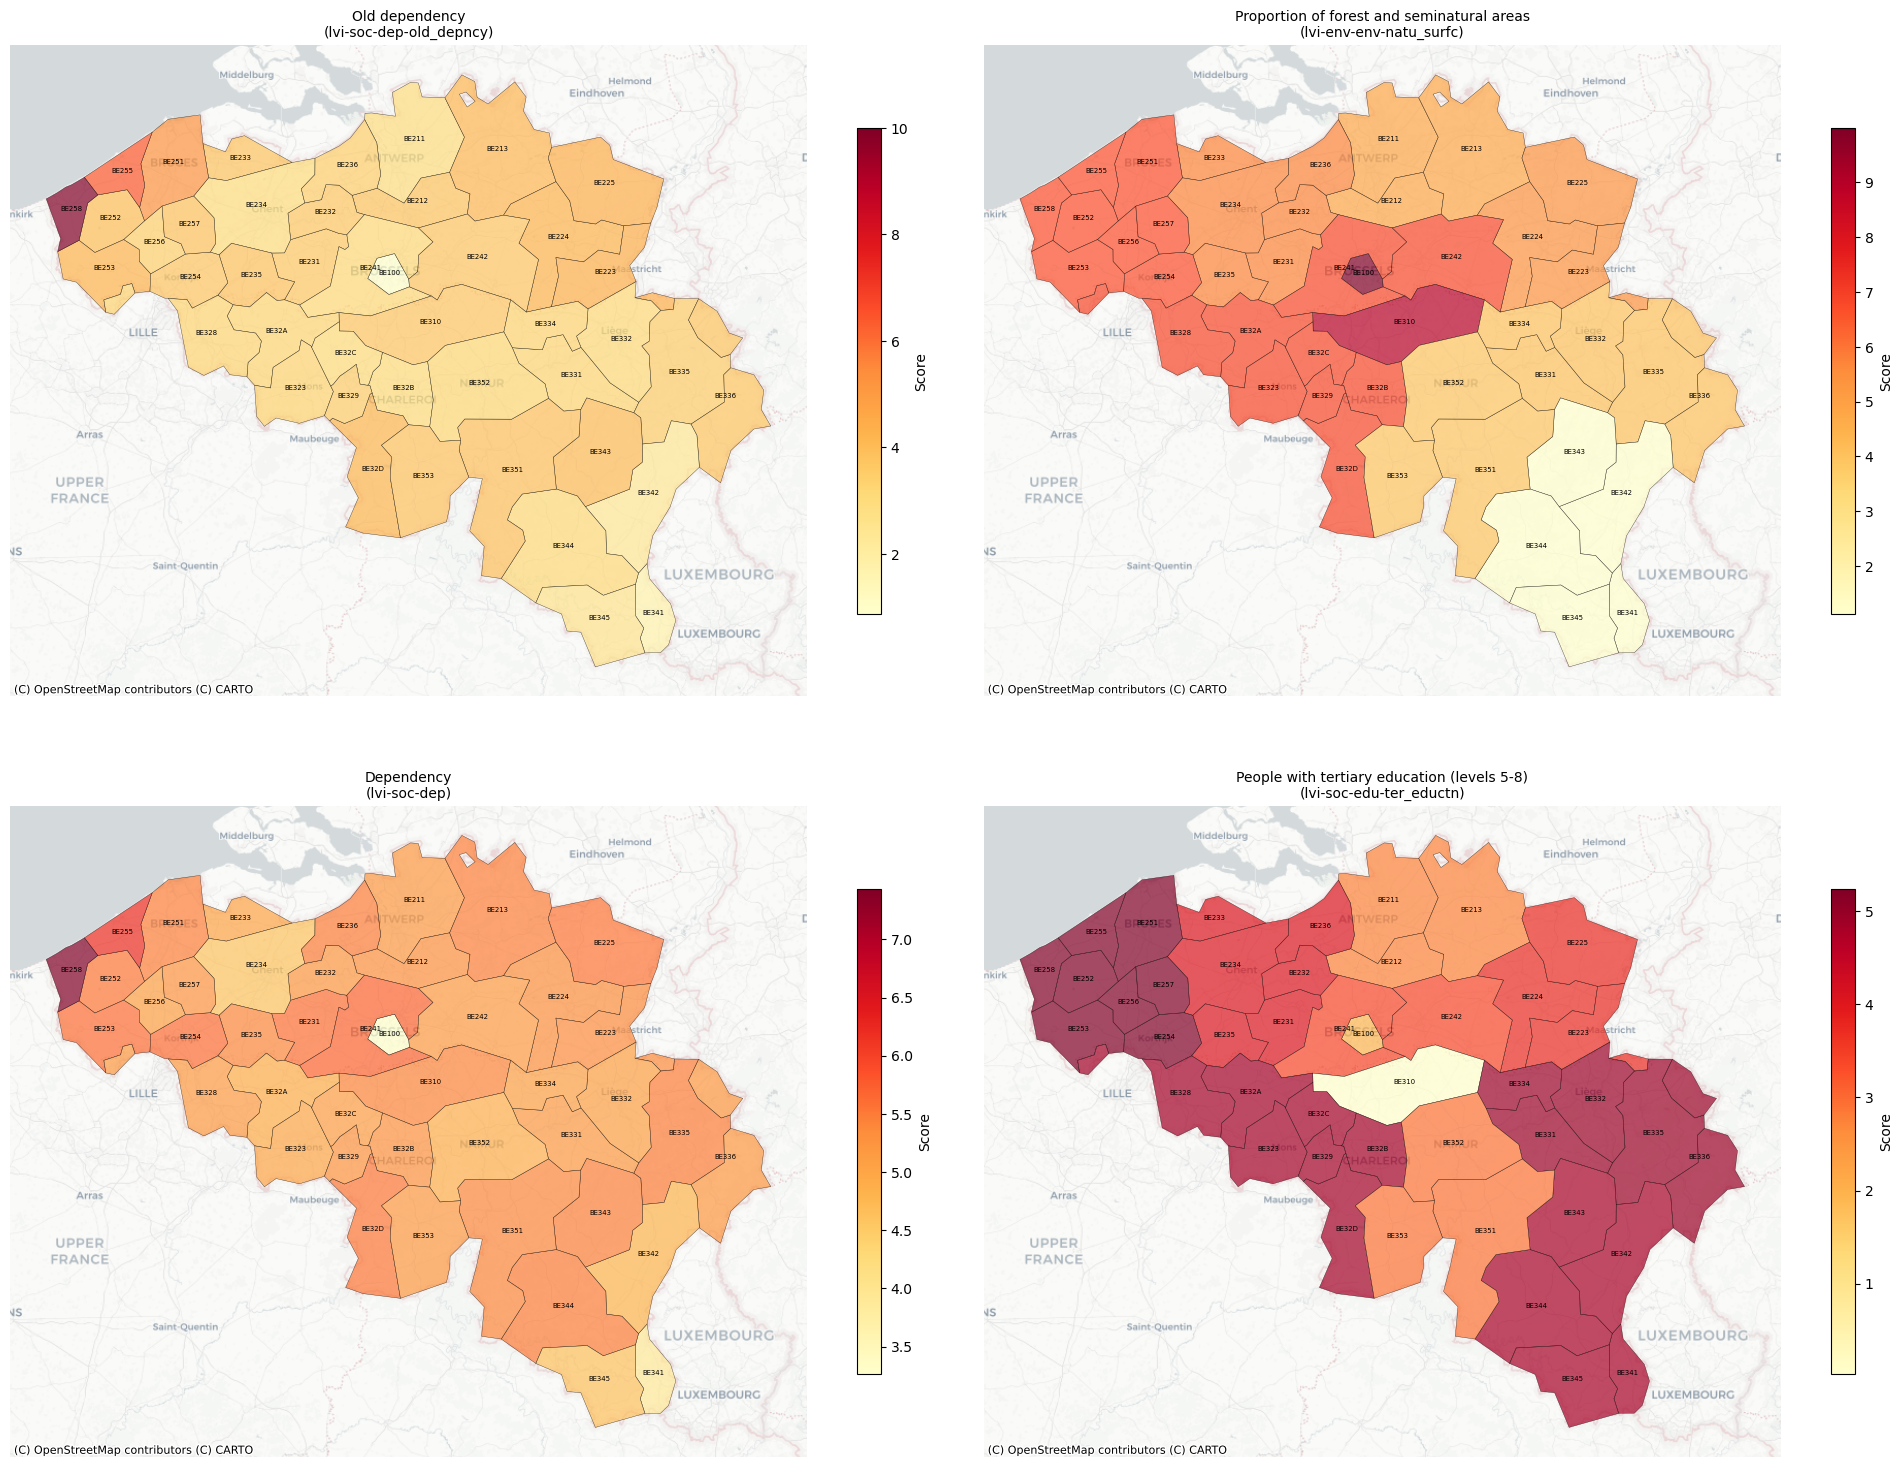

In [15]:
target_codes = ['lvi-soc-dep-old_depncy',
                'lvi-env-env-natu_surfc',
                'lvi-soc-dep',
                'lvi-soc-edu-ter_eductn'
                ]

# Create subplots (2 rows x 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
# Flatten axes for easy iteration
axes = axes.flatten()

for idx, code in enumerate(target_codes):
    ax = axes[idx]
    
    # Get description
    desc = vulnerabilities_df[vulnerabilities_df['vulnerability_code'] == code]['vulnerability_measure'].iloc[0]
    
    # Filter data for this specific vulnerability
    vul_data_filtered = vulnerabilities_df[vulnerabilities_df['vulnerability_code'] == code].copy()
    
    # Sort by year (descending) and keep latest
    vul_data_filtered = vul_data_filtered.sort_values('vulnerability_year', ascending=False)
    vul_data = vul_data_filtered.drop_duplicates(subset=['admin_unit_code'], keep='first')
    
    # Merge with NUTS3 polygons
    gdf_vul_map = nuts3_polygons.merge(
        vul_data, 
        left_on='NUTS_ID', 
        right_on='admin_unit_code', 
        how='left'
    )
    
    # Reproject to Web Mercator
    gdf_vul_map = gdf_vul_map.to_crs(epsg=3857)
    
    # Add labels
    for _, row in gdf_vul_map.iterrows():
        if pd.notna(row['vulnerability_score']):
            ax.annotate(
                text=f"{row['NUTS_ID']}",
                xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                ha='center', fontsize=5, color='black'
            )
    
    # Plot
    gdf_vul_map.plot(
        ax=ax,
        column='vulnerability_score',
        cmap='YlOrRd',
        legend=True,
        legend_kwds={'label': 'Score', 'shrink': 0.6},
        missing_kwds={'color': 'lightgrey', 'label': 'No Data'},
        alpha=0.7,
        edgecolor='black',
        linewidth=0.3
    )
    
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
    ax.set_axis_off()
    
    # Set title
    ax.set_title(f"{desc}\n({code})", fontsize=10)

# Turn off any unused axes if there are fewer than 4 codes
for i in range(len(target_codes), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

We will also load historical loss event data for the target country, to understand the frequency and severity of past catastrophes and their impact on economic losses and human fatalities. This historical perspective is essential for insurers to validate their risk models and make informed underwriting decisions.

Both vulnerability indicators and historical loss data will be integrated into our Knowledge Graph, allowing for complex queries such as: *Which NUTS3 regions have high social vulnerability and have experienced multiple severe flood events in the past 20 years?*

In [16]:
# Get unique NUTS codes from the economic exposure data
unique_nuts3_codes = econ_exposure_df['NUTS3'].dropna().unique()
unique_nuts2_codes = econ_exposure_df['NUTS2'].dropna().unique()
unique_nuts1_codes = econ_exposure_df['NUTS1'].dropna().unique()

all_losses_list = []

# Fetch NUTS3 losses
for nuts3_code in tqdm(unique_nuts3_codes, desc="Fetching NUTS3 loss data"):
    r_data = get_losses_by_country(country_alpha2, 3, DRMKC_TOKEN, nuts_filter=nuts3_code)
    
    if r_data and 'features' in r_data:
        props = [item['properties'] for item in r_data['features']]
        all_losses_list.extend(props)

# Fetch NUTS2 losses
for nuts2_code in tqdm(unique_nuts2_codes, desc="Fetching NUTS2 loss data"):
    r_data = get_losses_by_country(country_alpha2, 2, DRMKC_TOKEN, nuts_filter=nuts2_code)
    
    if r_data and 'features' in r_data:
        props = [item['properties'] for item in r_data['features']]
        all_losses_list.extend(props)

# Fetch NUTS1 losses
for nuts1_code in tqdm(unique_nuts1_codes, desc="Fetching NUTS1 loss data"):
    r_data = get_losses_by_country(country_alpha2, 1, DRMKC_TOKEN, nuts_filter=nuts1_code)
    
    if r_data and 'features' in r_data:
        props = [item['properties'] for item in r_data['features']]
        all_losses_list.extend(props)

# Create the final dataframe
losses_df = pd.DataFrame(all_losses_list)

print(f"Losses DataFrame shape: {losses_df.shape}")
print(f"  - Unique NUTS3 regions with losses: {losses_df[losses_df['admin_unit_level_code'] == 3]['admin_unit_code'].nunique()}")
print(f"  - Unique NUTS2 regions with losses: {losses_df[losses_df['admin_unit_level_code'] == 2]['admin_unit_code'].nunique()}")
print(f"  - Unique NUTS1 regions with losses: {losses_df[losses_df['admin_unit_level_code'] == 1]['admin_unit_code'].nunique()}")

Fetching NUTS3 loss data:   0%|          | 0/44 [00:00<?, ?it/s]

Fetching NUTS2 loss data:   0%|          | 0/11 [00:00<?, ?it/s]

Fetching NUTS1 loss data:   0%|          | 0/3 [00:00<?, ?it/s]

Losses DataFrame shape: (1228, 31)
  - Unique NUTS3 regions with losses: 44
  - Unique NUTS2 regions with losses: 11
  - Unique NUTS1 regions with losses: 3


In [17]:
# Compute event_start_date and event_end_date as datetime, from event_start_date_day, event_start_date_month, event_start_date_year, etc.
losses_df['event_start_date'] = pd.to_datetime(
    losses_df[['event_start_date_year', 'event_start_date_month', 'event_start_date_day']].rename(
        columns={
            'event_start_date_year': 'year', 
            'event_start_date_month': 'month', 
            'event_start_date_day': 'day'
        }
    )
)

losses_df['event_end_date'] = pd.to_datetime(
    losses_df[['event_end_date_year', 'event_end_date_month', 'event_end_date_day']].rename(
        columns={
            'event_end_date_year': 'year', 
            'event_end_date_month': 'month', 
            'event_end_date_day': 'day'
        }
    )
)

To exemplify this data, let us visualise some of the historical loss events for the target country, to understand their spatial distribution and impact. This data will later be key for our analysis of the relationship between hazard, vulnerability, and insurance penetration. Again the graph structure will shine for this type of complex multi-dimensional queries across dimensions and regions.

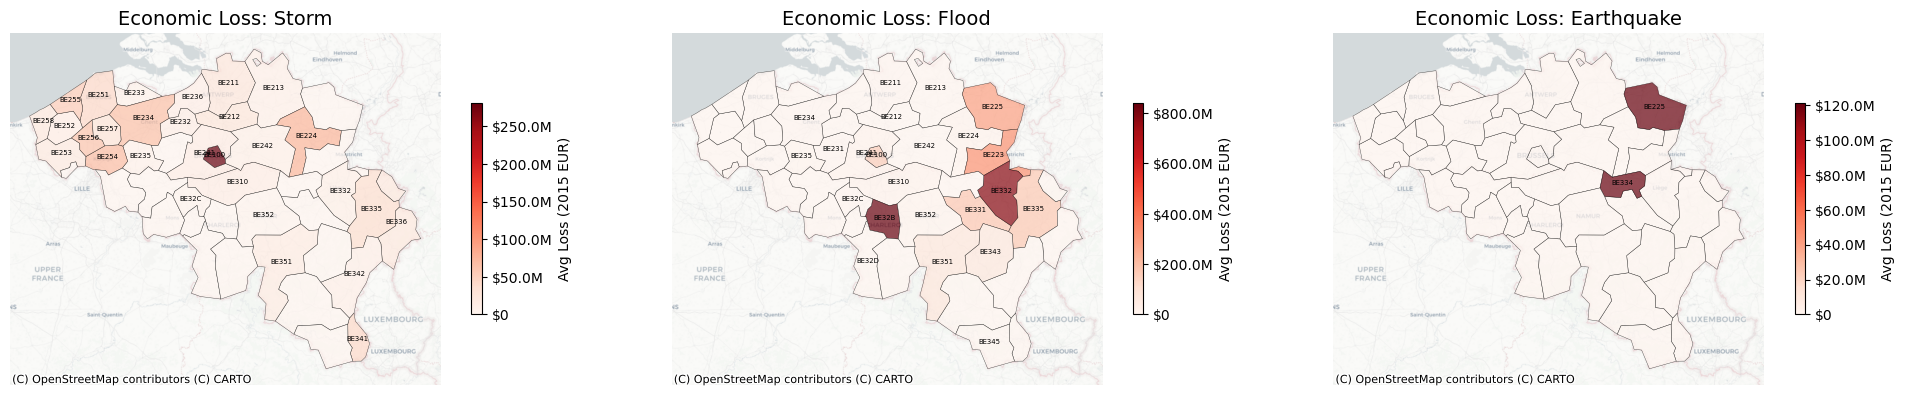

In [18]:
import math

# Filter for economic loss
loss_metric_mask = losses_df['metric'] == 'economic_loss_value'
losses_filtered = losses_df[loss_metric_mask].copy()

# Ensure numeric value
losses_filtered['value_2015_event_src_average'] = pd.to_numeric(losses_filtered['value_2015_event_src_average'], errors='coerce')

# Get unique hazard types
hazard_types = losses_filtered['hazard_type'].unique()
n_hazards = len(hazard_types)

if n_hazards > 0:
    # Determine grid dimensions
    n_cols = 3
    n_rows = math.ceil(n_hazards / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
    if n_hazards > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    for idx, hazard in enumerate(hazard_types):
        ax = axes[idx]
        
        # Filter by hazard
        hz_data = losses_filtered[losses_filtered['hazard_type'] == hazard]
        
        # Group by region (admin_unit_code) and sum the average loss
        hz_agg = hz_data.groupby('admin_unit_code')['value_2015_event_src_average'].sum().reset_index()
        
        # Merge with geometry
        # Use 'left' join to keep all polygons, fills with NaN/0 where no data
        gdf_loss_map = nuts3_polygons.merge(
            hz_agg, 
            left_on='NUTS_ID', 
            right_on='admin_unit_code', 
            how='left'
        )
        
        # Fill missing values and reproject
        gdf_loss_map['value_2015_event_src_average'] = gdf_loss_map['value_2015_event_src_average'].fillna(0)
        gdf_loss_map = gdf_loss_map.to_crs(epsg=3857)
        
        # Add labels
        for _, row in gdf_loss_map.iterrows():
            if pd.notna(row['value_2015_event_src_average']) and row['value_2015_event_src_average'] > 0:
                ax.annotate(
                    text=f"{row['NUTS_ID']}",
                    xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                    ha='center', fontsize=5, color='black'
                )
        
        # Plot
        gdf_loss_map.plot(
            ax=ax,
            column='value_2015_event_src_average',
            cmap='Reds',
            legend=True,
            legend_kwds={
                'label': 'Avg Loss (2015 EUR)', 
                'shrink': 0.6,
                'format': ticker.FuncFormatter(currency_fmt)
            },
            linewidth=0.3,
            edgecolor='black',
            alpha=0.7,
        )
        
        cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
        ax.set_axis_off()
        ax.set_title(f"Economic Loss: {hazard}", fontsize=14)

    # Hide empty axes
    for i in range(n_hazards, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No data found with metric='economic_loss_value'")

In [19]:
losses_df.head()

,event_end_date_month,admin_unit_country_code,hazard_type,value_2015_event_src_average,event_code,event_end_date_year,admin_unit_country_name,hazard_subtype,data_source_list,admin_unit_code,...,event_start_date_year,admin_unit_level_code,hazard_category,quantity_kind,event_end_date_day,admin_unit_parent_code,hazard_group_name,value_event_src_average,event_start_date,event_end_date
0,1,BE,Flood,0.0,FLBE199312200002,1994,Belgique/België,Riverine flood,"DFO,HANZE",BE258,...,1993,3,FL,count,1,BE25,Natural,0.0,1993-12-20,1994-01-01
1,1,BE,Flood,25.0,FLBE199312200002,1994,Belgique/België,Riverine flood,"DFO,HANZE",BE258,...,1993,3,FL,count,1,BE25,Natural,25.0,1993-12-20,1994-01-01
2,2,BE,Flood,0.0,FLBE199501220001,1995,Belgique/België,Riverine flood,"DFO,HANZE",BE258,...,1995,3,FL,count,7,BE25,Natural,0.0,1995-01-22,1995-02-07
3,2,BE,Flood,142.0,FLBE199501220001,1995,Belgique/België,Riverine flood,"DFO,HANZE",BE258,...,1995,3,FL,count,7,BE25,Natural,142.0,1995-01-22,1995-02-07
4,1,BE,Flood,0.0,FLBE200212240004,2003,Belgique/België,Riverine flood,"DFO,HANZE",BE258,...,2002,3,FL,count,8,BE25,Natural,0.0,2002-12-24,2003-01-08


## Knowledge Graph Schema Design

The power of a Knowledge Graph lies in linking concepts that are usually siloed in relational databases. For this use case, we propose a schema that centers on **Location (Region)** as the unifying entity.

### Graph Metamodel

Our schema connects three domains:

- **Geo-Spatial Domain**: `Country`, `Region`, `EconomicExposureCell`.
- **Risk Domain**: `Vulnerability`, `LossEvent`, `LossEventImpact`.
- **Financial Domain**: `InsuranceMetric`.

### Nodes & Properties

| Node Label | Source System | Key Properties | Description |
| :--- | :--- | :--- | :--- |
| **`Country`** | `pycountry` | `iso_a3`, `name` | Top-level market entity. |
| **`Region`** | `GISCO/NUTS` | `nuts_id`, `level`, `urbn_type` | The primary spatial unit for risk aggregation (NUTS1/2/3). |
| **`EconomicExposureCell`** | `LitPop` | `value`, `lat`/`lon` | Granular exposure unit (Total Insurable Value proxy). |
| **`Vulnerability`** | `DRMKC` | `code`, `name` | Abstract definition of a risk factor (e.g., "Social Deprivation"). |
| **`InsuranceMetric`** | `EIOPA` | `business_type`, `name` | Financial KPI definition (e.g., "GWP - Fire & Other Damage"). |
| **`LossEvent`** | `DRMKC` | `hazard_type`, `start_date` | A specific historical catastrophe event (e.g., "2021 Floods"). |

### Relationships (Semantics)

*   `(:Region)-[:PART_OF]->(:Region)`: Defines the administrative hierarchy (Roll-up logic).
*   `(:EconomicExposureCell)-[:LOCATED_IN]->(:Region)`: Spatial containment. Allows summing TIV by region.
*   `(:Region)-[:HAS_VULNERABILITY {score, year}]->(:Vulnerability)`: Temporal vulnerability assessment.
*   `(:Country)-[:REPORTED_FINANCIALS {value, year}]->(:InsuranceMetric)`: Financial performance time-series.
*   `(:LossEvent)-[:IMPACTED_REGION]->(:Region)`: Connects hazard history to specific locations.

## Neo4j Integration & Constraints

Finally we are ready to load all these datasets into Neo4j. To ensure data quality and query performance, we apply **Database constraints**.

### Data Integrity Strategy

*   **Uniqueness Constraints**: Prevent duplicate nodes for standard entities (Countries, Regions, Metrics). This ensures efficient `MERGE` operations during ingestion.
*   **Indexes**: Created on frequently queried properties (e.g., `LossEvent.year`, `Region.level`) to speed up downstream analytics and aggregations.


In [2]:
from neo4j import GraphDatabase

NEO4J_URI = os.getenv("NEO4J_URI", "bolt://localhost:7687")
NEO4J_USER = os.getenv("NEO4J_USER")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")
NEO4J_DATABASE = os.getenv("NEO4J_DATABASE")

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

# Verify connection
with driver.session(database=NEO4J_DATABASE) as session:
    result = session.run("RETURN 1 AS test")
    print(f"Neo4j connection successful: {result.single()['test'] == 1}")

Neo4j connection successful: True


In [21]:
# Create constraints and indexes for the schema
def create_schema(tx):
    # Node constraints (uniqueness)
    constraints = [
        "CREATE CONSTRAINT country_iso_a3 IF NOT EXISTS FOR (c:Country) REQUIRE c.iso_a3 IS UNIQUE",
        "CREATE CONSTRAINT region_nuts_code IF NOT EXISTS FOR (r:Region) REQUIRE r.nuts_code IS UNIQUE",
        "CREATE CONSTRAINT exposure_cell_code IF NOT EXISTS FOR (e:EconomicExposureCell) REQUIRE e.cell_code IS UNIQUE",
        "CREATE CONSTRAINT vulnerability_code IF NOT EXISTS FOR (v:Vulnerability) REQUIRE v.code IS UNIQUE",
        "CREATE CONSTRAINT insurance_metric_code IF NOT EXISTS FOR (m:InsuranceMetric) REQUIRE m.code IS UNIQUE",
        "CREATE CONSTRAINT loss_event_code IF NOT EXISTS FOR (l:LossEvent) REQUIRE l.event_code IS UNIQUE",
    ]
    
    for constraint in constraints:
        tx.run(constraint)
        
    # Indexes for faster lookups
    indexes = [
        "CREATE INDEX region_level IF NOT EXISTS FOR (r:Region) ON (r.level)",
        "CREATE INDEX loss_event_hazard IF NOT EXISTS FOR (l:LossEvent) ON (l.hazard_type)",
        "CREATE INDEX loss_event_year IF NOT EXISTS FOR (l:LossEvent) ON (l.year)",
    ]
    
    for index in indexes:
        tx.run(index)

with driver.session(database=NEO4J_DATABASE) as session:
    session.execute_write(create_schema)
    print("Schema constraints and indexes created successfully")

Schema constraints and indexes created successfully


## Data Ingestion Pipeline

We implement the ETL logic using **Cypher transactions**. The loading process is designed to be idempotent (using `MERGE`) and efficient (using batch processing).

### Loading Sequence

- **Administrative Backbone**: Create `Country` and `Region` hierarchy first. This forms the skeleton of the graph.
- **Granular Exposure**: Ingest `EconomicExposureCells` and link them to the lowest level regions (`LOCATED_IN` -> NUTS3).
- **Risk Factors**: Link `Region` nodes to `Vulnerability` definitions (`HAS_VULNERABILITY`).
- **Financial Layer**: Link the `Country` to `InsuranceMetric` nodes (`REPORTED_FINANCIALS`).
- **Event History**: CREATE `LossEvent` nodes and connect them to affected `Region`s (`IMPACTED_REGION`).

This "Outside-In" approach (Structure first, then Details) ensures referential integrity during the load.

In [22]:
# Load Country node
def load_country(tx, iso_a3, iso_a2, name):
    tx.run("""
        MERGE (c:Country {iso_a3: $iso_a3})
        SET c.iso_a2 = $iso_a2,
            c.name = $name
    """, iso_a3=iso_a3, iso_a2=iso_a2, name=name)

with driver.session(database=NEO4J_DATABASE) as session:
    session.execute_write(load_country, LOAD_COUNTRY_ISO_A3, country_alpha2, country_full)
    print(f"Country node created: {country_full} ({LOAD_COUNTRY_ISO_A3})")

Country node created: BELGIUM (BEL)


In [23]:
# Load Region nodes (NUTS1, NUTS2, NUTS3) with hierarchy
def load_regions_batch(tx, regions_data):
    tx.run("""
        UNWIND $regions AS region
        MERGE (r:Region {nuts_code: region.nuts_code})
        SET r.name = region.name,
            r.level = region.level,
            r.mount_type = region.mount_type,
            r.urbn_type = region.urbn_type,
            r.coast_type = region.coast_type
    """, regions=regions_data)

# Build lookup dictionaries for NUTS1 and NUTS2 names from the full NUTS dataset
nuts1_names = {}
nuts2_names = {}

for _, row in nuts_all[(nuts_all['CNTR_CODE'] == country_alpha2)].iterrows():
    nuts_id = row['NUTS_ID']
    name = row.get('NUTS_NAME', row.get('NAME_LATN', ''))
    level = row['LEVL_CODE']
    
    if level == 1:
        nuts1_names[nuts_id] = name
    elif level == 2:
        nuts2_names[nuts_id] = name

# Prepare unique regions from NUTS3 polygons
regions_to_load = []

for _, row in nuts3_polygons.iterrows():
    nuts_code = row['NUTS_ID']
    # NUTS3 region
    regions_to_load.append({
        'nuts_code': nuts_code,
        'name': row.get('NUTS_NAME', row.get('NAME_LATN', '')),
        'level': 3,
        'mount_type': int(row['MOUNT_TYPE']) if pd.notna(row.get('MOUNT_TYPE')) else None,
        'urbn_type': int(row['URBN_TYPE']) if pd.notna(row.get('URBN_TYPE')) else None,
        'coast_type': int(row['COAST_TYPE']) if pd.notna(row.get('COAST_TYPE')) else None
    })
    # Derive and add parent regions (NUTS2, NUTS1) with names from lookup
    nuts2_code = nuts_code[:4]
    nuts1_code = nuts_code[:3]
    regions_to_load.append({
        'nuts_code': nuts2_code, 
        'name': nuts2_names.get(nuts2_code), 
        'level': 2, 
        'mount_type': None,
        'urbn_type': None, 
        'coast_type': None
    })
    regions_to_load.append({
        'nuts_code': nuts1_code, 
        'name': nuts1_names.get(nuts1_code), 
        'level': 1, 
        'mount_type': None,
        'urbn_type': None, 
        'coast_type': None
    })

# Deduplicate
seen = set()
unique_regions = []
for r in regions_to_load:
    if r['nuts_code'] not in seen:
        seen.add(r['nuts_code'])
        unique_regions.append(r)

with driver.session(database=NEO4J_DATABASE) as session:
    session.execute_write(load_regions_batch, unique_regions)
    print(f"Loaded {len(unique_regions)} unique Region nodes")

Loaded 58 unique Region nodes


In [24]:
# Create Region hierarchy relationships: NUTS3 -> NUTS2 -> NUTS1 -> Country
def create_region_hierarchy(tx, country_iso_a3):
    # NUTS3 -> NUTS2
    tx.run("""
        MATCH (r3:Region)
        WHERE r3.level = 3
        WITH r3, substring(r3.nuts_code, 0, 4) AS parent_code
        MATCH (r2:Region {nuts_code: parent_code})
        MERGE (r3)-[:PART_OF]->(r2)
    """)
    
    # NUTS2 -> NUTS1
    tx.run("""
        MATCH (r2:Region)
        WHERE r2.level = 2
        WITH r2, substring(r2.nuts_code, 0, 3) AS parent_code
        MATCH (r1:Region {nuts_code: parent_code})
        MERGE (r2)-[:PART_OF]->(r1)
    """)
    
    # NUTS1 -> Country
    tx.run("""
        MATCH (r1:Region)
        WHERE r1.level = 1
        MATCH (c:Country {iso_a3: $country_iso_a3})
        MERGE (r1)-[:PART_OF]->(c)
    """, country_iso_a3=country_iso_a3)

with driver.session(database=NEO4J_DATABASE) as session:
    session.execute_write(create_region_hierarchy, LOAD_COUNTRY_ISO_A3)
    print("Region hierarchy relationships created (NUTS3 -> NUTS2 -> NUTS1 -> Country)")

Region hierarchy relationships created (NUTS3 -> NUTS2 -> NUTS1 -> Country)


In [25]:
# Load EconomicExposureCell nodes with LOCATED_IN relationship to Region
def load_exposure_cells_batch(tx, cells_data):
    tx.run("""
        UNWIND $cells AS cell
        MERGE (e:EconomicExposureCell {cell_code: cell.cell_code})
        SET e.lat = cell.lat,
            e.lon = cell.lon,
            e.value = cell.value
        WITH e, cell
        MATCH (r:Region {nuts_code: cell.nuts3_code})
        MERGE (e)-[:LOCATED_IN]->(r)
    """, cells=cells_data)

# Prepare exposure cell data in batches
batch_size = 5000
exposure_records = []

for idx, row in econ_exposure_df.iterrows():
    if pd.notna(row['NUTS3']) and row['value'] > 0:  # Only load cells with value > 0
        exposure_records.append({
            'cell_code': f"{row['latitude']:.6f}_{row['longitude']:.6f}",
            'lat': float(row['latitude']),
            'lon': float(row['longitude']),
            'value': float(row['value']),
            'nuts3_code': row['NUTS3']
        })

# Load in batches
with driver.session(database=NEO4J_DATABASE) as session:
    total_loaded = 0
    for i in range(0, len(exposure_records), batch_size):
        batch = exposure_records[i:i+batch_size]
        session.execute_write(load_exposure_cells_batch, batch)
        total_loaded += len(batch)
        print(f"Loaded {total_loaded}/{len(exposure_records)} EconomicExposureCell nodes...")
    
    print(f"Completed loading {total_loaded} EconomicExposureCell nodes with LOCATED_IN relationships")

Loaded 5000/55118 EconomicExposureCell nodes...
Loaded 10000/55118 EconomicExposureCell nodes...
Loaded 15000/55118 EconomicExposureCell nodes...
Loaded 20000/55118 EconomicExposureCell nodes...
Loaded 25000/55118 EconomicExposureCell nodes...
Loaded 30000/55118 EconomicExposureCell nodes...
Loaded 35000/55118 EconomicExposureCell nodes...
Loaded 40000/55118 EconomicExposureCell nodes...
Loaded 45000/55118 EconomicExposureCell nodes...
Loaded 50000/55118 EconomicExposureCell nodes...
Loaded 55000/55118 EconomicExposureCell nodes...
Loaded 55118/55118 EconomicExposureCell nodes...
Completed loading 55118 EconomicExposureCell nodes with LOCATED_IN relationships


In [26]:
# Load Vulnerability nodes and HAS_VULNERABILITY relationships
def load_vulnerabilities_batch(tx, vul_definitions):
    # Create Vulnerability definition nodes
    tx.run("""
        UNWIND $vulnerabilities AS v
        MERGE (vul:Vulnerability {code: v.code})
        SET vul.name = v.name,
            vul.parent_category = v.parent_category
    """, vulnerabilities=vul_definitions)

def create_vulnerability_relationships_batch(tx, vul_data):
    # Create relationships with score and year on the relationship
    tx.run("""
        UNWIND $data AS d
        MATCH (r:Region {nuts_code: d.nuts_code})
        MATCH (v:Vulnerability {code: d.vul_code})
        MERGE (r)-[rel:HAS_VULNERABILITY {year: d.year}]->(v)
        SET rel.score = d.score
    """, data=vul_data)

# Extract unique vulnerability definitions
vul_definitions = vulnerabilities_df.drop_duplicates(subset=['vulnerability_code'])[
    ['vulnerability_code', 'vulnerability_measure', 'vulnerability_parent_code']
].rename(columns={
    'vulnerability_code': 'code',
    'vulnerability_measure': 'name', 
    'vulnerability_parent_category': 'parent_category'
}).to_dict('records')

# Prepare vulnerability relationship data
vul_rel_data = []
for _, row in vulnerabilities_df.iterrows():
    if pd.notna(row.get('admin_unit_code')) and pd.notna(row.get('vulnerability_score')):
        vul_rel_data.append({
            'nuts_code': row['admin_unit_code'],
            'vul_code': row['vulnerability_code'],
            'year': int(row['vulnerability_year']) if pd.notna(row.get('vulnerability_year')) else None,
            'score': float(row['vulnerability_score'])
        })

with driver.session(database=NEO4J_DATABASE) as session:
    # Load vulnerability definitions
    session.execute_write(load_vulnerabilities_batch, vul_definitions)
    print(f"Loaded {len(vul_definitions)} Vulnerability definition nodes")
    
    # Load relationships in batches
    batch_size = 5000
    for i in range(0, len(vul_rel_data), batch_size):
        batch = vul_rel_data[i:i+batch_size]
        session.execute_write(create_vulnerability_relationships_batch, batch)
        print(f"Loaded {min(i+batch_size, len(vul_rel_data))}/{len(vul_rel_data)} HAS_VULNERABILITY relationships...")
    
    print(f"Completed loading vulnerability data")

Loaded 60 Vulnerability definition nodes
Loaded 5000/73472 HAS_VULNERABILITY relationships...
Loaded 10000/73472 HAS_VULNERABILITY relationships...
Loaded 15000/73472 HAS_VULNERABILITY relationships...
Loaded 20000/73472 HAS_VULNERABILITY relationships...
Loaded 25000/73472 HAS_VULNERABILITY relationships...
Loaded 30000/73472 HAS_VULNERABILITY relationships...
Loaded 35000/73472 HAS_VULNERABILITY relationships...
Loaded 40000/73472 HAS_VULNERABILITY relationships...
Loaded 45000/73472 HAS_VULNERABILITY relationships...
Loaded 50000/73472 HAS_VULNERABILITY relationships...
Loaded 55000/73472 HAS_VULNERABILITY relationships...
Loaded 60000/73472 HAS_VULNERABILITY relationships...
Loaded 65000/73472 HAS_VULNERABILITY relationships...
Loaded 70000/73472 HAS_VULNERABILITY relationships...
Loaded 73472/73472 HAS_VULNERABILITY relationships...
Completed loading vulnerability data


In [27]:
# Load InsuranceMetric nodes and REPORTED_FINANCIALS relationships
def load_insurance_metrics_batch(tx, metrics_definitions):
    tx.run("""
        UNWIND $metrics AS m
        MERGE (im:InsuranceMetric {code: m.code})
        SET im.name = m.name,
            im.business_type = m.business_type
    """, metrics=metrics_definitions)

def create_insurance_relationships_batch(tx, data, country_iso_a3):
    tx.run("""
        UNWIND $data AS d
        MATCH (c:Country {iso_a3: $country_iso_a3})
        MATCH (m:InsuranceMetric {code: d.metric_code})
        MERGE (c)-[rel:REPORTED_FINANCIALS {year: d.year}]->(m)
        SET rel.value = d.value
    """, data=data, country_iso_a3=country_iso_a3)

# Create unique metric code from Item + Business type
eiopa_country_df['metric_code'] = eiopa_country_df['Item'] + '_' + eiopa_country_df['Business type'].str.replace(' ', '_')

# Extract unique metric definitions
metrics_definitions = eiopa_country_df.drop_duplicates(subset=['metric_code'])[
    ['metric_code', 'Item', 'Business type']
].rename(columns={
    'metric_code': 'code',
    'Item': 'name',
    'Business type': 'business_type'
}).to_dict('records')

# Prepare relationship data
insurance_rel_data = []
for _, row in eiopa_country_df.iterrows():
    if pd.notna(row.get('Value')):
        insurance_rel_data.append({
            'metric_code': row['metric_code'],
            'year': int(row['Reference period']),
            'value': float(row['Value'])
        })

with driver.session(database=NEO4J_DATABASE) as session:
    # Load metric definitions
    session.execute_write(load_insurance_metrics_batch, metrics_definitions)
    print(f"Loaded {len(metrics_definitions)} InsuranceMetric definition nodes")
    
    # Load relationships in batches
    batch_size = 1000
    for i in range(0, len(insurance_rel_data), batch_size):
        batch = insurance_rel_data[i:i+batch_size]
        session.execute_write(create_insurance_relationships_batch, batch, LOAD_COUNTRY_ISO_A3)
    
    print(f"Loaded {len(insurance_rel_data)} REPORTED_FINANCIALS relationships")

Loaded 37 InsuranceMetric definition nodes
Loaded 647 REPORTED_FINANCIALS relationships


In [28]:
# Load LossEvent nodes and relationships to Regions
def load_loss_events_batch(tx, events_data):
    tx.run("""
        UNWIND $events AS e
        MERGE (l:LossEvent {event_code: e.event_code})
        SET l.hazard_type = e.hazard_type,
            l.hazard = e.hazard,
            l.hazard_subtype = e.hazard_subtype,
            l.hazard_group_name = e.hazard_group_name,
            l.asset = e.asset,
            l.event_name = e.event_name,
            l.start_date = date(e.start_date),
            l.end_date = date(e.end_date),
            l.year = e.year,
            l.nuts_level = e.nuts_level
        WITH l, e
        MATCH (r:Region {nuts_code: e.nuts_code, level: e.nuts_level})
        MERGE (l)-[:IMPACTED_REGION]->(r)
    """, events=events_data)

def load_loss_impacts_batch(tx, impacts_data):
    tx.run("""
        UNWIND $impacts AS i
        MATCH (l:LossEvent {event_code: i.event_code})
        MERGE (impact:LossEventImpact {event_code: i.event_code, metric: i.metric})
        SET impact.value = i.value,
            impact.year = i.year
        MERGE (l)-[:HAS_IMPACT]->(impact)
    """, impacts=impacts_data)

# Prepare loss event data
# Create unique event_code from event components (include nuts_level to ensure uniqueness across levels)
losses_df['event_code'] = (
    losses_df['event_code'].astype(str) + '_' + 
    losses_df['admin_unit_code'].astype(str) + '_L' +
    losses_df['admin_unit_level_code'].astype(str)
)

loss_events = []
for _, row in losses_df.drop_duplicates(subset=['event_code']).iterrows():
    start_date = row['event_start_date'].strftime('%Y-%m-%d') if pd.notna(row.get('event_start_date')) else None
    end_date = row['event_end_date'].strftime('%Y-%m-%d') if pd.notna(row.get('event_end_date')) else None
    
    loss_events.append({
        'event_code': row['event_code'],
        'hazard_type': row.get('hazard_type'),
        'hazard': row.get('hazard'),
        'hazard_subtype': row.get('hazard_subtype'),
        'hazard_group_name': row.get('hazard_group_name'),
        'asset': row.get('asset'),
        'event_name': row.get('event_name'),
        'start_date': start_date,
        'end_date': end_date,
        'year': int(row['event_start_date_year']) if pd.notna(row.get('event_start_date_year')) else None,
        'nuts_code': row['admin_unit_code'],
        'nuts_level': int(row['admin_unit_level_code']) if pd.notna(row.get('admin_unit_level_code')) else None
    })

# Filter out events with missing dates or nuts_level
loss_events = [e for e in loss_events if e['start_date'] and e['end_date'] and e['nuts_code'] and e['nuts_level']]

# Prepare loss impact data
loss_impacts = []
for _, row in losses_df.iterrows():
    if pd.notna(row.get('metric')) and pd.notna(row.get('value_2015_event_src_average')):
        loss_impacts.append({
            'event_code': row['event_code'],
            'metric': row['metric'],
            'value': float(row['value_2015_event_src_average']) if pd.notna(row.get('value_2015_event_src_average')) else None,
            'year': int(row['event_start_date_year']) if pd.notna(row.get('event_start_date_year')) else None
        })

with driver.session(database=NEO4J_DATABASE) as session:
    # Load loss events
    batch_size = 1000
    for i in range(0, len(loss_events), batch_size):
        batch = loss_events[i:i+batch_size]
        session.execute_write(load_loss_events_batch, batch)
        print(f"Loaded {min(i+batch_size, len(loss_events))}/{len(loss_events)} LossEvent nodes...")
    
    print(f"Completed loading {len(loss_events)} LossEvent nodes with IMPACTED_REGION relationships")
    
    # Summary by NUTS level
    level_counts = {}
    for e in loss_events:
        level = e['nuts_level']
        level_counts[level] = level_counts.get(level, 0) + 1
    for level, count in sorted(level_counts.items()):
        print(f"  - NUTS{level}: {count} events")
    
    # Load loss impacts
    for i in range(0, len(loss_impacts), batch_size):
        batch = loss_impacts[i:i+batch_size]
        session.execute_write(load_loss_impacts_batch, batch)
        print(f"Loaded {min(i+batch_size, len(loss_impacts))}/{len(loss_impacts)} HAS_IMPACT relationships...")
    
    print(f"Completed loading {len(loss_impacts)} loss impact relationships")

Loaded 733/733 LossEvent nodes...
Completed loading 733 LossEvent nodes with IMPACTED_REGION relationships
  - NUTS1: 100 events
  - NUTS2: 283 events
  - NUTS3: 350 events
Loaded 1000/1228 HAS_IMPACT relationships...
Loaded 1228/1228 HAS_IMPACT relationships...
Completed loading 1228 loss impact relationships


In [29]:
# Verify the loaded graph - count nodes and relationships
def get_graph_stats(tx):
    stats = {}
    
    # Node counts
    result = tx.run("MATCH (n) RETURN labels(n)[0] AS label, count(n) AS count")
    stats['nodes'] = {record['label']: record['count'] for record in result}
    
    # Relationship counts
    result = tx.run("MATCH ()-[r]->() RETURN type(r) AS type, count(r) AS count")
    stats['relationships'] = {record['type']: record['count'] for record in result}
    
    return stats

with driver.session(database=NEO4J_DATABASE) as session:
    stats = session.execute_read(get_graph_stats)
    
    print("=== Neo4j Graph Statistics ===\n")
    print("Node Counts:")
    for label, count in sorted(stats['nodes'].items()):
        print(f"  {label}: {count:,}")
    
    print("\nRelationship Counts:")
    for rel_type, count in sorted(stats['relationships'].items()):
        print(f"  {rel_type}: {count:,}")

=== Neo4j Graph Statistics ===

Node Counts:
  Country: 1
  EconomicExposureCell: 55,118
  InsuranceMetric: 37
  LossEvent: 733
  LossEventImpact: 1,228
  Region: 58
  Vulnerability: 60

Relationship Counts:
  HAS_IMPACT: 1,228
  HAS_VULNERABILITY: 73,472
  IMPACTED_REGION: 733
  LOCATED_IN: 55,118
  PART_OF: 58
  REPORTED_FINANCIALS: 141
